**Find Trends in the data for modeling forward pass**

Similar to `experiments/step_time_analysis.ipynb` we are using current batch data we gathered in profiling to estimate forward pass times with a model

In [41]:
# get data from csv into df
import pandas as pd
import json

def parse_csv(path: str) -> pd.DataFrame:
    """
    Read a CSV file and return a DataFrame.
    
    Args:
        path (str): The path to the CSV file.
        
    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV file.
    """
    df = pd.read_csv(path)
    return df

def format_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    parse the num_scheduled_tokens column from string to json to parse info on decodes and prefills
    """
    df['num_scheduled_tokens'] = df['num_scheduled_tokens'].apply(lambda x: x.replace("'", '"'))
    df['num_scheduled_tokens'] = df['num_scheduled_tokens'].apply(json.loads)

    def process_tokens(token_dict):
        """
        Process token dictionary to extract decode/prefill statistics
        """
        num_decodes = 0
        num_prefills = 0
        sum_decode_tokens = 0
        sum_prefill_tokens = 0
        
        for key, value in token_dict.items():
            if value == 1:
                # Decode
                num_decodes += 1
                sum_decode_tokens += value
            else:
                # Prefill (anything > 1)
                num_prefills += 1
                sum_prefill_tokens += value
        
        return pd.Series({
            'num_decodes': num_decodes,
            'num_prefills': num_prefills,
            'sum_decode_tokens': sum_decode_tokens,
            'sum_prefill_tokens': sum_prefill_tokens
        })

    df[['num_decodes', 'num_prefills', 'sum_decode_tokens', 'sum_prefill_tokens']] = df['num_scheduled_tokens'].apply(process_tokens)
    df.drop(columns=['num_scheduled_tokens', 'num_decodes'], inplace=True) # Num_decodes is the same sum_decode_tokens, so we can drop it

    # add num_total_requests column = num_decodes + num_prefills
    df['num_total_requests'] = df['num_prefills'] + df['sum_decode_tokens']
    return df

In [43]:
path = 'execution_stats.csv'

df = parse_csv(path)
df = format_data(df)
df.head()

,num_total_scheduled_tokens,scheduled_new_reqs,execute_time,scheduler_time,update_time,num_prefills,sum_decode_tokens,sum_prefill_tokens,num_total_requests
0,1,[],0.002067,0.000028,0.000029,0,1,0,1
1,1,[],0.002111,0.000030,0.000029,0,1,0,1
2,1,[],0.002122,0.000029,0.000030,0,1,0,1
3,1,[],0.002060,0.000027,0.000030,0,1,0,1
4,1,[],0.002029,0.000028,0.000028,0,1,0,1


In [44]:
# try to find correlation between execute_time and num_decodes, num_prefills, sum_decode_tokens, sum_prefill_tokens
correlation = df[['execute_time', 'num_prefills', 'sum_decode_tokens', 'sum_prefill_tokens', 'num_total_requests', 'num_total_scheduled_tokens']].corr()
print(correlation)

                            execute_time  num_prefills  sum_decode_tokens  \
execute_time                    1.000000      0.382660           0.940085   
num_prefills                    0.382660      1.000000           0.387696   
sum_decode_tokens               0.940085      0.387696           1.000000   
sum_prefill_tokens              0.383948      0.841005           0.332984   
num_total_requests              0.940278      0.401917           0.999880   
num_total_scheduled_tokens      0.559484      0.845946           0.527161   

                            sum_prefill_tokens  num_total_requests  \
execute_time                          0.383948            0.940278   
num_prefills                          0.841005            0.401917   
sum_decode_tokens                     0.332984            0.999880   
sum_prefill_tokens                    1.000000            0.344898   
num_total_requests                    0.344898            1.000000   
num_total_scheduled_tokens            0.

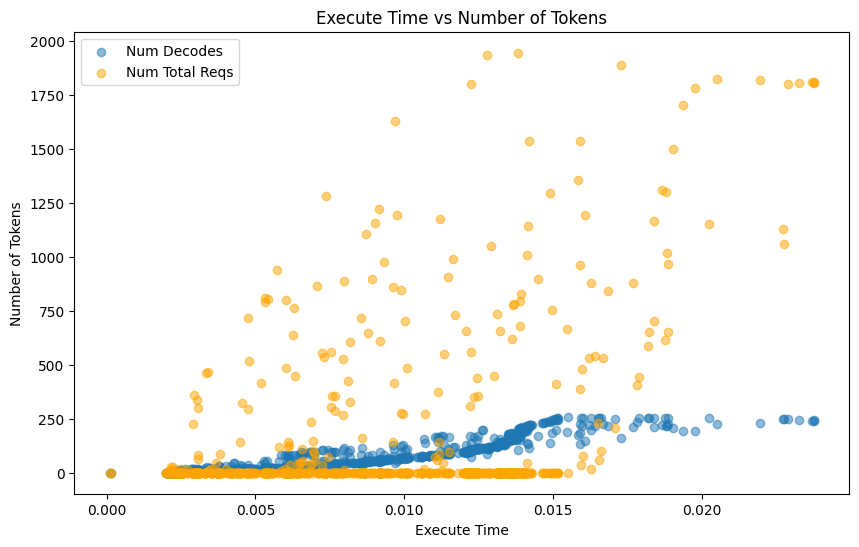

In [40]:
# plot execute_time vs num_decodes
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['execute_time'], df['sum_decode_tokens'], alpha=0.5, label='Num Decodes')
plt.scatter(df['execute_time'], df['sum_prefill_tokens'], alpha=0.5, label='Num Total Reqs', color='orange')
# plt.scatter(df['execute_time'], df['sum_prefill_tokens'], alpha=0.5, label='Sum Prefill Tokens', color='green')
plt.xlabel('Execute Time')
plt.ylabel('Number of Tokens')
plt.title('Execute Time vs Number of Tokens')
plt.legend()
plt.show()

In [78]:
# try dt regression to predict execute_time based on num_prefills, sum_decode_tokens, sum_prefill_tokens
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

df = parse_csv('execution_stats_5000_100.csv')
df = format_data(df)

X = df[['num_prefills','sum_prefill_tokens', 'num_total_requests']]
y = df['execute_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42)
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f"Decision Tree Regression Score: {score:.8f}")

# try tree regression on a new dataset

df = parse_csv('execution_stats.csv')
df = format_data(df)
X = df[['num_prefills', 'sum_prefill_tokens', 'num_total_requests']]
y = df['execute_time']

score = model.score(X, y)
print(f"Decision Tree Regression Score on new dataset: {score:.8f}")

Decision Tree Regression Score: 0.95852155
Decision Tree Regression Score on new dataset: 0.73367259


In [80]:
# train a nonlinear regression model to predict execute_time based on sum_decode_tokens
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df = parse_csv('execution_stats.csv')
df = format_data(df)
X = df[['sum_decode_tokens']]
y = df['execute_time']


poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X[['sum_decode_tokens']])
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.95, random_state=42)
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train_poly)
# Evaluate the polynomial model
score_poly = model_poly.score(X_test_poly, y_test_poly)
print(f'Polynomial Model R^2 Score: {score_poly:.8f}')


df = parse_csv('execution_stats_5000_100.csv')
df = format_data(df)
X_test_poly = poly.transform(df[['sum_decode_tokens']])
y_test_poly = df['execute_time']
score_poly_new = model_poly.score(X_test_poly, y_test_poly)
print(f'Polynomial Model R^2 Score on new dataset: {score_poly_new:.8f}')

Polynomial Model R^2 Score: 0.94177164
Polynomial Model R^2 Score on new dataset: 0.57373559
